In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from scipy import stats
# imported libraries

# Introduction
### Topic Question: How do meat and vegetable consumption patterns differ across the Asian Pacific and European regions. What factors (like GDP or urbanisation) help explain and predict these differences?
### Why our research is relevant
---
There is always the debate in diet of meats versus vegetables, and we want to find out if they really are mutually exclusive. We also want to analyse the trends in meat and vegetable consumption over the years, and how they play off of each other. In this project, we attempt to answer these questions with a data "story":

1. Do Europeans consume more meat than Asians?
2. Do Asians consume more vegetables than Europeans?
3. Is there a trade-off between meat and vegetable consumption (if a country consumes more meat do they also consume less veg)?
4. How variable are diets within each region?
5. Are the observed differences statistically significant?
6. What does bootstrapping tell us about confidence in our findings?
7. Does GDP per capita predict meat consumption?

# Chapter 1: Preliminary Cleanup and merging
---

We collated the datasets we would use and performed a merger on them for ease of access. In the below code you will witness the loading of our data, data cleaning and preperation (renaming), data merging and data validation. The script follows a standard ETL (Extract, Transform, Load) pattern so that we can enrich our data analysis with a dataset where each row represents a country to year observation, with columns for diet (meat, veg, calories), economy (GDP), and demographics (urban population).

In [40]:
# Load our data
meat_df = pd.read_csv("datasets/asia_europe_meat_consumption.csv") #
veg_df = pd.read_csv("datasets/vegetable-consumption-per-capita.csv")  
caloric_df = pd.read_csv("datasets/daily-per-capita-caloric-supply.csv") 
urban_df = pd.read_csv("datasets/share-of-population-urban.csv") 
gdp_per_cap_df = pd.read_csv("datasets/gdp-per-capita-worldbank.csv")

# Taming the raw column names into something we can actually work with
veg_df = veg_df.rename(columns={
    "Vegetables | 00002918 || Food available for consumption | 0645pc || kilograms per year per capita": "Vegetables_kg_per_capita" # Much better!
})
caloric_df = caloric_df.rename(columns={
    "Daily calorie supply per person": "Daily_caloric_supply" 
})
urban_df = urban_df.rename(columns={
    "Urban population (% of total population)": "Urban_population_pct" # Standardised
})
gdp_per_cap_df = gdp_per_cap_df.rename(columns={
    "GDP per capita, PPP (constant 2021 international $)": "GDP_per_capita" 
})

# Merge datasets on entity, code, and year can't have a diet study without knowing what people eat right 
merged_df = meat_df.merge(
    veg_df[["Entity", "Code", "Year", "Vegetables_kg_per_capita"]],  # perform inner join, we need meat AND veg data
    on=["Entity", "Code", "Year"],
    how="inner" # Enforce segregation because only countries with both meat and veg data make the cut
).merge(
    caloric_df[["Entity", "Code", "Year", "Daily_caloric_supply"]],
    on=["Entity", "Code", "Year"],
    how="left"  # This just says "keep all our diet countries, add calories if avail"
).merge(
    urban_df[["Entity", "Code", "Year", "Urban_population_pct"]],
    on=["Entity", "Code", "Year"],
    how="left"  
).merge(
    gdp_per_cap_df[["Entity", "Code", "Year", "GDP_per_capita"]],
    on=["Entity", "Code", "Year"],
    how="left"  
)
#quick check for missing values
print("Missing values in merged dataset:")
print(merged_df.isnull().sum())

#voila merger done
merged_df.to_csv("datasets/merged_meat_veg_caloric_urban.csv", index=False) 

# Display the first few rows of the merged dataset
print("\nFirst 5 rows of our master dataset:")
print(merged_df.head())

Missing values in merged dataset:
Entity                                                                                                           0
Code                                                                                                             0
Year                                                                                                             0
region                                                                                                           0
Total_Meat_kg_per_capita                                                                                         0
Meat, poultry | 00002734 || Food available for consumption | 0645pc || kilograms per year per capita             0
Meat, beef and buffalo | 00002731 || Food available for consumption | 0645pc || kilograms per year per capita    0
Meat, sheep and goat | 00002732 || Food available for consumption | 0645pc || kilograms per year per capita      0
Meat, pig | 00002733 || Food available for con

# Chapter 2: Exploratory Data Analysis
---

Before we recklessly charge into the bootstrapping and linear regression, Exploratory Data Analysis (EDA) is an absolute necessity. We need to make sure that the data we're working with is substantial and detect and anomalies whilst looking for possible trade-offs or correlations. In this chapter, we aim to compare the central tendency, spread, and overall distribution of meat and vegetable consumption across Asia and Europe in 2022.

## 2.1 Statistical analysis

In [41]:
#using the first iteration of our merged dataset
merged_df = pd.read_csv("datasets/merged_meat_fruit_veg.csv")

# Filter data for twozerotwotwo
merged_2022 = merged_df[merged_df['Year'] == 2022]

# seperate data by region
europe_data = merged_2022[merged_2022['region'] == 'Europe']
asia_data = merged_2022[merged_2022['region'] == 'Asia']

# Write out some summary statistics
# --- CONFIG ---
VARS = {
    "Total_Meat_kg_per_capita": "Meat (kg/capita)",
    "Vegetables_kg_per_capita": "Vegetables (kg/capita)",
}
REGIONS = ["Asia", "Europe"]
DECIMALS = 2

def fmt(x):
    return ("{:." + str(DECIMALS) + "f}").format(x)

def region_block(df, region, vars_map):
    d = df[df["region"] == region]
    lines = [region, "-" * len(region)]
    for col, label in vars_map.items():
        s = d[col].dropna()
        if s.empty:
            continue
        mean   = s.mean()
        median = s.median()
        std    = s.std()
        q1     = s.quantile(0.25)
        q3     = s.quantile(0.75)
        iqr    = q3 - q1
        mn, mx = s.min(), s.max()
        cv     = (std / mean * 100) if mean != 0 else np.nan

        lines += [
            label,
            f"Count : {s.size}",
            f"Mean : {fmt(mean)}",
            f"Median : {fmt(median)}",
            f"Std : {fmt(std)}",
            f"CV% : {fmt(cv)}",
            f"Q1 : {fmt(q1)}",
            f"Q3 : {fmt(q3)}",
            f"IQR : {fmt(iqr)}",
            f"Min : {fmt(mn)}",
            f"Max : {fmt(mx)}",
            ""  # blank line between variables
        ]
    return "\n".join(lines)

# Filter to 2022 (as you already did)
# merged_2022 = merged_df[merged_df['Year'] == 2022]

# Print blocks
for r in REGIONS:
    print(region_block(merged_2022, r, VARS))
    print()  # extra space between regions

Asia
----
Meat (kg/capita)
Count : 46
Mean : 47.52
Median : 39.30
Std : 32.19
CV% : 67.73
Q1 : 20.28
Q3 : 68.93
IQR : 48.65
Min : 4.40
Max : 132.26

Vegetables (kg/capita)
Count : 46
Mean : 138.17
Median : 128.76
Std : 82.47
CV% : 59.68
Q1 : 75.64
Q3 : 192.55
IQR : 116.91
Min : 23.18
Max : 408.04


Europe
------
Meat (kg/capita)
Count : 39
Mean : 73.80
Median : 72.85
Std : 15.37
CV% : 20.83
Q1 : 65.30
Q3 : 82.87
IQR : 17.58
Min : 35.43
Max : 104.16

Vegetables (kg/capita)
Count : 39
Mean : 165.39
Median : 159.19
Std : 67.98
CV% : 41.10
Q1 : 114.77
Q3 : 183.69
IQR : 68.92
Min : 78.47
Max : 379.14




### Meat consumption findings from 2.1 (2022)
<table>
  <thead>
    <tr>
      <th>Statistic</th>
      <th>Asia (kg/capita)</th>
      <th>Europe (kg/capita)</th>
      <th>Interpretation & Story</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>Mean</b></td>
      <td>47.52</td>
      <td>73.80</td>
      <td>On average, a European consumes around 55% more meat annually than an Asian. This is a substantial dietary gap.</td>
    </tr>
    <tr>
      <td><b>Median</b></td>
      <td>39.30</td>
      <td>72.85</td>
      <td>The median confirms this is a widespread trend.</td>
    </tr>
    <tr>
      <td><b>Std. Deviation</b></td>
      <td>32.19</td>
      <td>15.37</td>
      <td>Meat consumption in Asia is highly variable (approx. 32 kg), more than double Europe’s (approx. 15 kg).</td>
    </tr>
    <tr>
      <td><b>Range (Min–Max)</b></td>
      <td>4.40 – 132.26</td>
      <td>35.43 – 104.16</td>
      <td>Asia spans extremes: vegetarian nations (e.g. India) to the world’s top consumers (Mongolia). Europe’s “floor” is higher, with no ultra-low meat countries.</td>
    </tr>
  </tbody>
</table>

### Vegetable consumption findings from 2.1 (2022)

<table>
  <thead>
    <tr>
      <th>Statistic</th>
      <th>Asia (kg/capita)</th>
      <th>Europe (kg/capita)</th>
      <th>What this means</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>Mean</b></td>
      <td>138.17</td>
      <td>165.39</td>
      <td>Europeans consume approx 20% more vegetables on average than Asians, which challenges the “meat and potatoes” stereotype.</td>
    </tr>
    <tr>
      <td><b>Median</b></td>
      <td>128.76</td>
      <td>159.19</td>
      <td>The median values are a clear amounts closer to their respective means than they were for meat. What this means is the distributions are less skewed. Despite this, the gap between the medians (approx. 30 kg) is still substantial enough.</td>
    </tr>
    <tr>
      <td><b>Std. Deviation</b></td>
      <td>82.47</td>
      <td>67.98</td>
      <td>Asia shows greater variability, with countries ranging from low intake to global leaders like China.</td>
    </tr>
    <tr>
      <td><b>Range (Min–Max)</b></td>
      <td>23.18 – 408.04</td>
      <td>78.47 – 379.14</td>
      <td>Asia includes both the lowest and highest consumers in the dataset. Europe’s intake is more clustered with a higher baseline.</td>
    </tr>
  </tbody>
</table>


## 2.2 Pretty visuals to aid in EDA

To go even further beyond summary statistics, we employ different visual aids such as histograms and scatter plots to visualise the "shape" of the data. In this sections we're keeping an eye out for patterns and visual anomalies. To further reveal the difference in consumption across regions.

c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


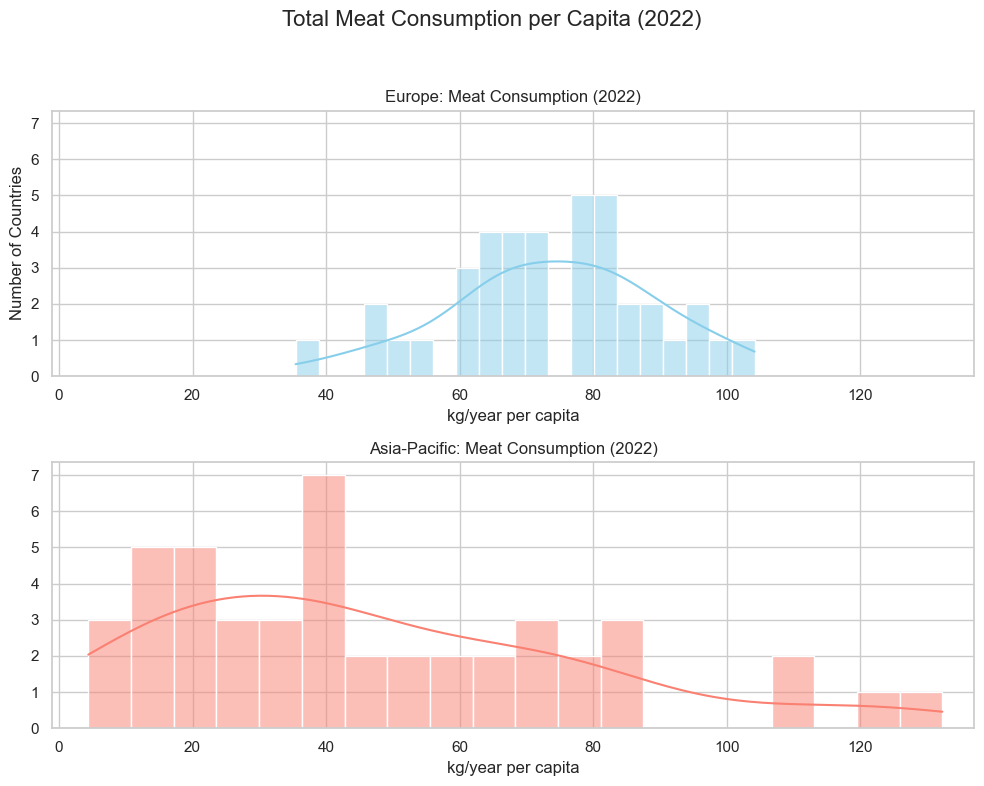

c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


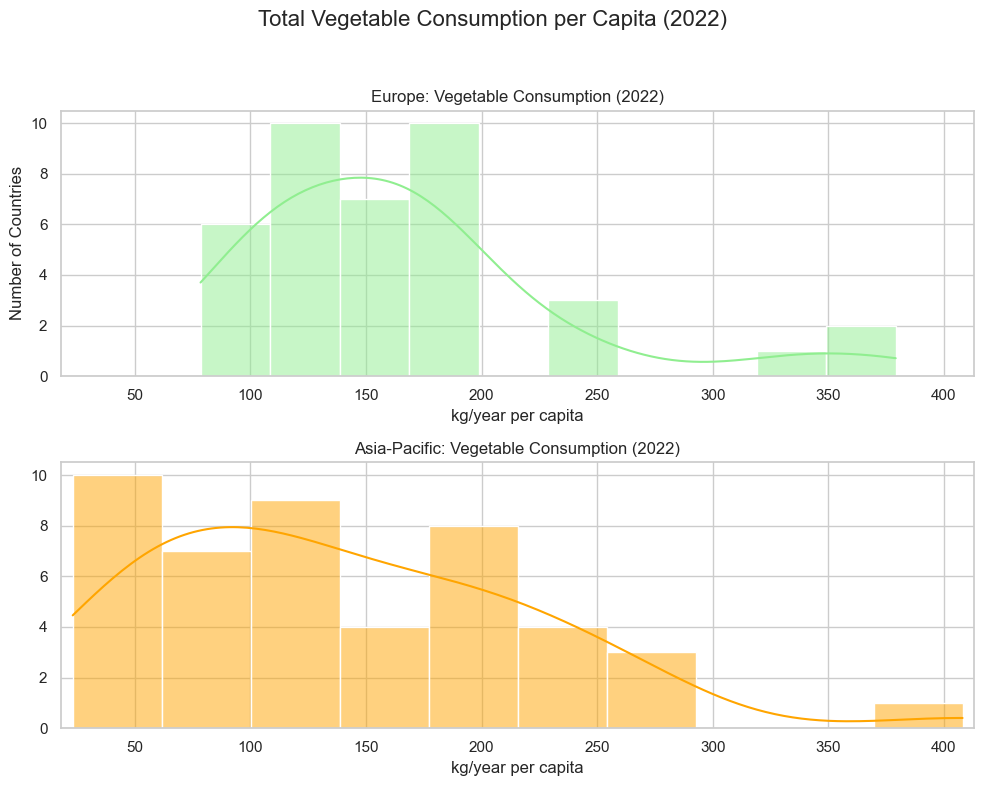

In [42]:
#  Meat Consumption Histogram
# Get combined min and max for x-axis
min_x_meat = min(europe_data['Total_Meat_kg_per_capita'].min(), asia_data['Total_Meat_kg_per_capita'].min())
max_x_meat = max(europe_data['Total_Meat_kg_per_capita'].max(), asia_data['Total_Meat_kg_per_capita'].max())
xlim_meat = (int(min_x_meat) - 5, int(max_x_meat) + 5)

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharey=True)

# Europe histogram
sns.histplot(europe_data['Total_Meat_kg_per_capita'], color='skyblue', kde=True, bins=20, ax=axs[0])
axs[0].set_title('Europe: Meat Consumption (2022)')
axs[0].set_xlabel('kg/year per capita')
axs[0].set_ylabel('Number of Countries')
axs[0].set_xlim(xlim_meat)
axs[0].grid(True)

# Asia-Pacific histogram
sns.histplot(asia_data['Total_Meat_kg_per_capita'], color='salmon', kde=True, bins=20, ax=axs[1])
axs[1].set_title('Asia-Pacific: Meat Consumption (2022)')
axs[1].set_xlabel('kg/year per capita')
axs[1].set_ylabel('')
axs[1].set_xlim(xlim_meat)
axs[1].grid(True)

fig.suptitle('Total Meat Consumption per Capita (2022)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Vegetable Consumption Histogram  #
# Get combined min and max for x-axis
min_x_veg = min(europe_data['Vegetables_kg_per_capita'].min(), asia_data['Vegetables_kg_per_capita'].min())
max_x_veg = max(europe_data['Vegetables_kg_per_capita'].max(), asia_data['Vegetables_kg_per_capita'].max())
xlim_veg = (int(min_x_veg) - 5, int(max_x_veg) + 5)

# Set up side-by-side plots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharey=True)

# Europe histogram
sns.histplot(europe_data['Vegetables_kg_per_capita'], color='lightgreen', kde=True, bins=10, ax=axs[0])
axs[0].set_title('Europe: Vegetable Consumption (2022)')
axs[0].set_xlabel('kg/year per capita')
axs[0].set_ylabel('Number of Countries')
axs[0].set_xlim(xlim_veg)
axs[0].grid(True)

# Asia-Pacific histogram
sns.histplot(asia_data['Vegetables_kg_per_capita'], color='orange', kde=True, bins=10, ax=axs[1])
axs[1].set_title('Asia-Pacific: Vegetable Consumption (2022)')
axs[1].set_xlabel('kg/year per capita')
axs[1].set_ylabel('')
axs[1].set_xlim(xlim_veg)
axs[1].grid(True)


fig.suptitle('Total Vegetable Consumption per Capita (2022)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

From our findings in 2.2, we can surmise the following:

The histograms for meat consumption tell us:

- Europe distribution (top): The distribution is tight, and approximately normal (bell shaped curve), it is also centered around 70-85 kg/annually. This visual helps us confirm the low standard deviation, showing that most European countries cluster within a somehwat narrow range of high meat consumption. There are however some outliers.

- Asia distribution (bottom): The distribution is heavily right-skewed. The majority of Asian countries are clustered at the lower end of the scale (below approx. 60 kg/annually), which forms a higher peak. Moreover, we can see a smaller number of countries with exceptionally high meat consumption. This visual captures the concept of high variance and also the effect of extreme outliers.

The histograms for vegetable consumption tell us:

- Europe distribution (top): The distribution is more spread out than it was for meat but still maintains a recognisable, roughly normal shape centered around 150-200 kg/annually. The bulk of the data falls within a single prominent bin which indicates a "typically European" level of vegetable consumption does exist, albeit with a slight bit more variation than seen in the meat histogram.

- Asia distribution (bottom): This distribution is very different. It is bimodal, suggesting two distinct groupings of countries within Asia. The first peak aligns with the lower end of the European range, while the second and smaller peak represents a group of countries with consumption above 250 kg/annually. Most notable thing is, the plot clearly shows a massive outlier on the far right. One single country where the consumption is exceeding 400 kg every year, a clear outlier. This visualizes an extremely high standard deviation and confirms that there is no single "typical" Asian level of vegetable consumption.

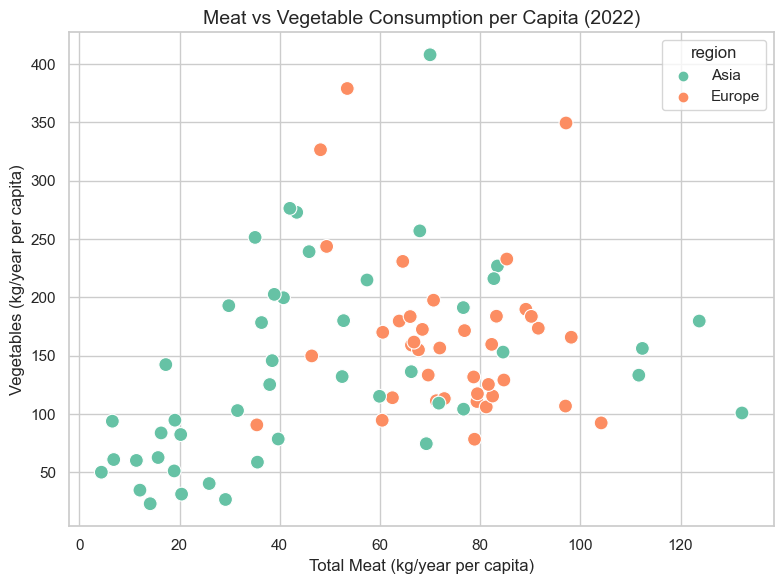

In [43]:
# Load the dataset
merged_df = pd.read_csv("datasets/merged_meat_fruit_veg.csv")

# Filter for 2022 data
merged_2022 = merged_df[merged_df['Year'] == 2022]

# Create scatterplot with regression line
plt.figure(figsize=(8, 6))

# Overlay points with color by region
sns.scatterplot(
    data=merged_2022,
    x='Total_Meat_kg_per_capita',
    y='Vegetables_kg_per_capita',
    hue='region',
    palette='Set2',
    s=100,
    legend=True
)

plt.title('Meat vs Vegetable Consumption per Capita (2022)', fontsize=14)
plt.xlabel('Total Meat (kg/year per capita)')
plt.ylabel('Vegetables (kg/year per capita)')
plt.grid(True)
plt.tight_layout()
plt.show()

The above scatter plot shows significantly higher mean/median meat consumption in Europe and the incredibly high variance (low floor, high ceiling) in Asia that we calculated previously in 2.1.

Both regions show a wide vertical spread, confirming high variance in vegetable consumption due to the outliers.

New finding: Meat and vegetable consumption are not mutually exclusive, nor are they strongly linked.

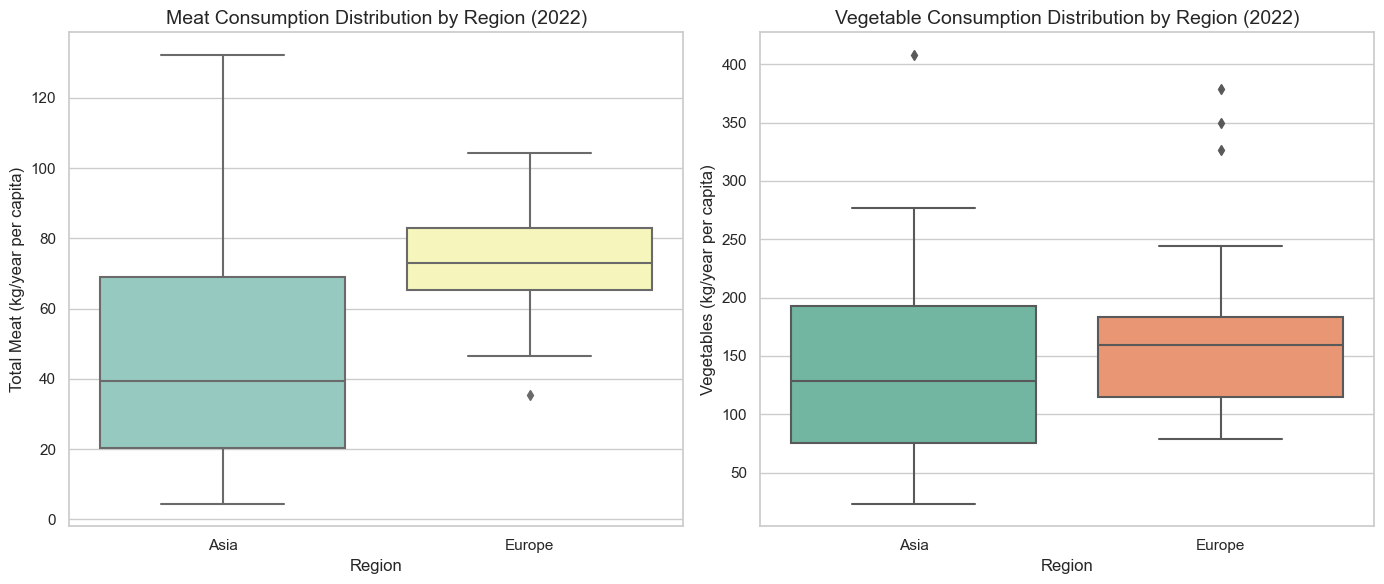

In [44]:
# Load dataset
merged_df = pd.read_csv("datasets/merged_meat_fruit_veg.csv")

# Set figure size for two plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Box plot for Meat consumption
sns.boxplot(
    data=merged_2022,
    x='region',
    y='Total_Meat_kg_per_capita',
    palette='Set3',
    ax=axs[0]
)
axs[0].set_title('Meat Consumption Distribution by Region (2022)', fontsize=14)
axs[0].set_xlabel('Region')
axs[0].set_ylabel('Total Meat (kg/year per capita)')
axs[0].grid(True, axis='y')

# Box plot for Vegetable consumption
sns.boxplot(
    data=merged_2022,
    x='region',
    y='Vegetables_kg_per_capita',
    palette='Set2',
    ax=axs[1]
)
axs[1].set_title('Vegetable Consumption Distribution by Region (2022)', fontsize=14)
axs[1].set_xlabel('Region')
axs[1].set_ylabel('Vegetables (kg/year per capita)')
axs[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

In the meat plot, the box for Europe is higher and tighter than Asia's, confirming Europeans consume more meat with far less country variation.

In the vegetable plot, The European box is higher, but both regions show vertical spreads (long whiskers), and highlight extreme outliers with high variance.

# Chapter 3: Hypothesis Testing through Permutation - Meat Consumption
---
From the EDA, we can see that Europeans seem to eat more meat than Asians, at least on average. Let us test if that is true. We will take the null hypothesis as "Europeans and Asians' meat consumptions per capita are distributed the same", with the alternative hypothesis being that they are not distributed the same.

## 3.1 Testing if Europe really does eat more meat

Mean meat consumption per capita in Europe is : 73.8 kg/capita/year
Mean meat consumption per capita in Asia is : 47.52 kg/capita/year
Difference of mean meat consumption between EU and Asia is : 26.28
95% of differences of means sampled lie between -12.29 and 12.11
One-sided p-value (EU > Asia): 0.0000
Two-sided p-value:             0.0000


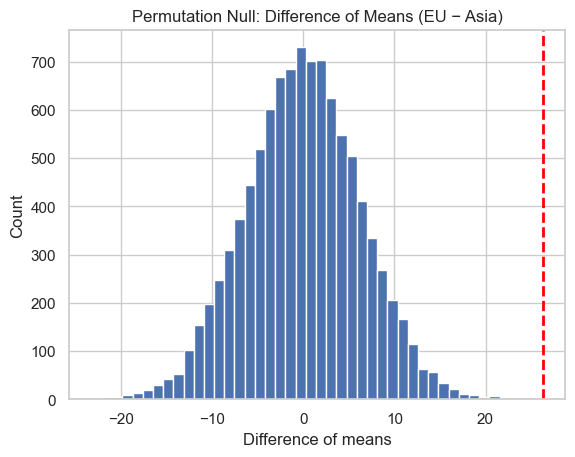

In [45]:
# Let's do hypothesis testing to see if European countries really do eat more meat!
# The way this will work is that for each country there is a meat consumed per capita value.

# Function to find diff of means as this will be important
def diff_of_means(data1, data2) :
    return np.mean(data1) - np.mean(data2)

eu_meat = europe_data['Total_Meat_kg_per_capita']
ap_meat = asia_data['Total_Meat_kg_per_capita']

# We first find the mean meat consumption for the EU and AP.
# Then, we find the observed difference in means.
eu_mean_meat = np.mean(eu_meat)
ap_mean_meat = np.mean(ap_meat)
print(f"Mean meat consumption per capita in Europe is : {np.round(eu_mean_meat, 2)} kg/capita/year")
print(f"Mean meat consumption per capita in Asia is : {np.round(ap_mean_meat, 2)} kg/capita/year")
obsvd_diff_of_means = diff_of_means(eu_meat, ap_meat)
print(f"Difference of mean meat consumption between EU and Asia is : {abs(np.round(obsvd_diff_of_means, 2))}")

# Now, let's do some bootstrap resampling.
# Concatenate the two arrays of EU meat consumption and AP meat consumption.
# Initialise an array to store the differences in means
concat_meat = np.concatenate((eu_meat, ap_meat))
meandiffs = []
samples = 10000

# Repeat the following 10k times:
# Shuffle the new array, then label the first X as "EU" and the rest as "AP"
# Find means for each, and find the difference.
# Append the difference to the diff of means array
for i in range(samples) :
    np.random.shuffle(concat_meat)
    shuffle_EU = concat_meat[:len(eu_meat)]
    shuffle_AP = concat_meat[len(eu_meat):]
    
    shuffle_diff_of_means = diff_of_means(shuffle_EU, shuffle_AP)
    meandiffs.append(shuffle_diff_of_means)

# Now, we should have 10k diff's of means
# Find 95% CI for the diff of means
conf_int_means = np.percentile(meandiffs, (2.5, 97.5))
print(f"95% of differences of means sampled lie between {conf_int_means[0]:.2f} and {conf_int_means[1]:.2f}")
# Draw histogram of diff of means, and show the observed as a vertical line

# p-values
# One-sided (EU > Asia): proportion of null diffs >= observed
p_val_one_sided = np.mean(meandiffs >= obsvd_diff_of_means)
# Two-sided: extremeness by absolute value
p_val_two_sided = np.mean(np.abs(meandiffs) >= abs(obsvd_diff_of_means))

print(f"One-sided p-value (EU > Asia): {p_val_one_sided:.4f}")
print(f"Two-sided p-value:             {p_val_two_sided:.4f}")

# Plot null distribution with observed diff
plt.figure()
plt.hist(meandiffs, bins=40)
plt.axvline(obsvd_diff_of_means, linestyle='--', linewidth=2, color='red')
plt.title("Permutation Null: Difference of Means (EU − Asia)")
plt.xlabel("Difference of means")
plt.ylabel("Count")
plt.show()


### Analysis
---
As can be seen, the observed difference in means between the mean meat consumption and Europe and that of Asia is far outside of the 95% confidence interval, with a p-value of 0.0001 or less. This shows that there is a definite difference between the distribution of meat consumption per capita in Europe and Asia, and that this is not a product of random chance. 

## 3.2 Bootstrap Resampling and Hypothesis Testing 2
---
We can also see from the EDA that Europeans have slightly more vegetable consumption than Asians as well. This could be a sign that they also eat more vegetables, but could also be a product of random chance. We will first use bootstrap replicates to see the distribution of mean vegetable consumption for both regions.

In [46]:
# Helper function to generate a bootstrap sample
# This should take an array-like data and take a bootstrap sample,
# then take some sort of statistical measurment from it

def bootstrap_replicate_1d(data, func) :
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

# ------------------------------------- x ------------------------------------ #

# Helper function to draw samples amount of bootstrap mean replicates from the data
# Should take the data and the number of samples to take
# Function is mentioned here as the mean

def draw_bootstrap_means(data, samples = 1) :
    means = np.zeros(samples)
    
    for i in range(samples) :
        means[i] = bootstrap_replicate_1d(data, np.mean)
        
    return means

95% of mean European vegetable consumptions per capita sampled lie between 145.46 and 187.83 kg/capita/year
95% of mean Asian vegetable consumptions per capita sampled lie between 115.41 and 162.63 kg/capita/year


c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


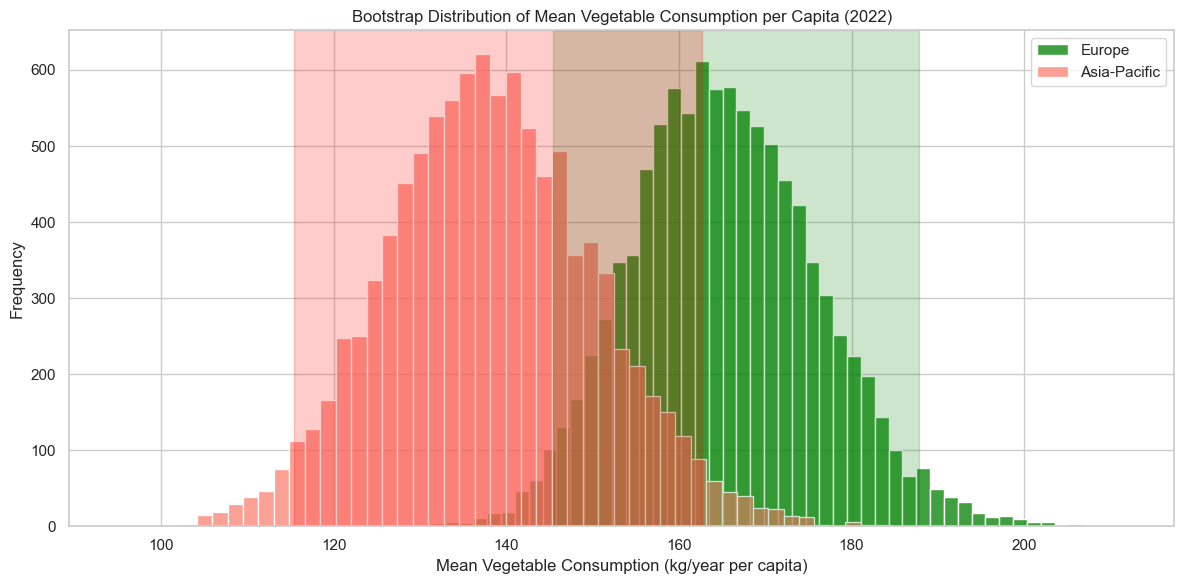

In [47]:
# -------- Bootstrap Replicate Analysis of mean vegetable consumption -------- #

# This code should generate a list of 10k bootstrap replicate means for eu_veg and ap_veg
# Then, generate a 95% confint for each
# Followed by a nice histogram that shows the two means in the same plot along with darker highlighting for the 95%'s

eu_veg = europe_data['Vegetables_kg_per_capita']
ap_veg = asia_data['Vegetables_kg_per_capita']

# Generate BS means
eu_bs_means = draw_bootstrap_means(eu_veg, 10000)
ap_bs_means = draw_bootstrap_means(ap_veg, 10000)

# Calculate confidence intervals
conf_int_means_eu = np.percentile(eu_bs_means, (2.5, 97.5))
conf_int_means_ap = np.percentile(ap_bs_means, (2.5, 97.5))
print(f"95% of mean European vegetable consumptions per capita sampled lie between {conf_int_means_eu[0]:.2f} and {conf_int_means_eu[1]:.2f} kg/capita/year")
print(f"95% of mean Asian vegetable consumptions per capita sampled lie between {conf_int_means_ap[0]:.2f} and {conf_int_means_ap[1]:.2f} kg/capita/year")

# Draw two histograms of the means
# Europe as blue, Asia as salmon
# On the same set of axes
# 95% conf innt should be highlighted somehow

# Plot histograms
plt.figure(figsize=(12, 6))

sns.histplot(eu_bs_means, bins=50, color='green', label='Europe')
sns.histplot(ap_bs_means, bins=50, color='salmon', label='Asia-Pacific')

# Shade confidence intervals
plt.axvspan(conf_int_means_eu[0], conf_int_means_eu[1], color='green', alpha=0.2)
plt.axvspan(conf_int_means_ap[0], conf_int_means_ap[1], color='red', alpha=0.2)

# Labels and legend
plt.title('Bootstrap Distribution of Mean Vegetable Consumption per Capita (2022)')
plt.xlabel('Mean Vegetable Consumption (kg/year per capita)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Analysis
---
As we can see, the distributions of mean vegetable consumption in Europe and Asia are somewhat close together - though there is a favoring towards Europe - so further testing will be required to discern if the difference is statsitcally significant.

Mean vegetable consumption per capita in Europe is : 165.39 kg/capita/year
Mean vegetable consumption per capita in Asia is : 138.17 kg/capita/year
Difference of mean vegetable consumption between EU and Asia is : 27.21
95% of differences of means sampled lie between -32.50 and 33.21
One-sided p-value (EU > Asia): 0.0511
Two-sided p-value:             0.1030


c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


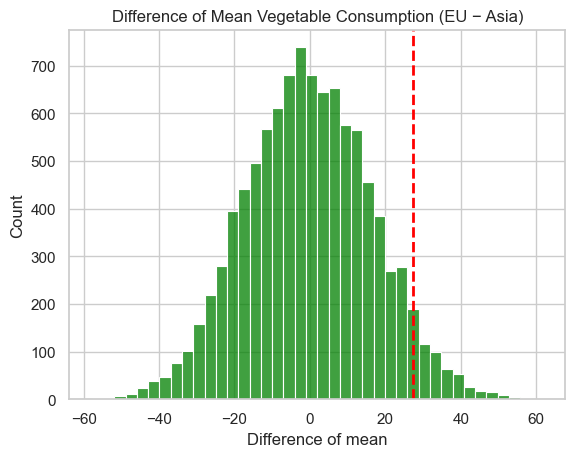

In [48]:
# --------- Hypothesis testing on Europe v Asia Vegetable consumption -------- #

# Null hypo: Europe and Asia's vegetable consumptions are distributed the same
# Alt hypo: They aren't

# We first find the mean vegetable consumption for the EU and AP.
# Then, we find the observed difference in means.
eu_mean_veg = np.mean(eu_veg)
ap_mean_veg = np.mean(ap_veg)
print(f"Mean vegetable consumption per capita in Europe is : {eu_mean_veg:.2f} kg/capita/year")
print(f"Mean vegetable consumption per capita in Asia is : {ap_mean_veg:.2f} kg/capita/year")
obsvd_diff_of_means = diff_of_means(eu_veg, ap_veg)
print(f"Difference of mean vegetable consumption between EU and Asia is : {abs(obsvd_diff_of_means):.2f}")

# ------------------------------------- x ------------------------------------ #

# Now, let's do some bootstrap resampling.
# Concatenate the two arrays of EU vegetable consumption and AP vegetable consumption.
# Initialise an array to store the differences in means
concat_veg = np.concatenate((eu_veg, ap_veg))
meandiffs = []
samples = 10000

# Repeat the following 10k times:
# Shuffle the new array, then label the first X as "EU" and the rest as "AP"
# Find means for each, and find the difference.
# Append the difference to the diff of means array
for i in range(samples) :
    np.random.shuffle(concat_veg)
    shuffle_EU = concat_veg[:len(eu_veg)]
    shuffle_AP = concat_veg[len(eu_veg):]
    
    shuffle_diff_of_means = diff_of_means(shuffle_EU, shuffle_AP)
    meandiffs.append(shuffle_diff_of_means)

# Now, we should have 10k diff's of means
# Find 95% CI for the diff of means
conf_int_means = np.percentile(meandiffs, (2.5, 97.5))
print(f"95% of differences of means sampled lie between {conf_int_means[0]:.2f} and {conf_int_means[1]:.2f}")
# Draw histogram of diff of means, and show the observed as a vertical line

# ------------------------------------- x ------------------------------------ #

# p-values
# One-sided (EU > Asia): proportion of null diffs >= observed
p_val_one_sided = np.mean(meandiffs >= obsvd_diff_of_means)
# Two-sided: extremeness by absolute value
p_val_two_sided = np.mean(np.abs(meandiffs) >= abs(obsvd_diff_of_means))

print(f"One-sided p-value (EU > Asia): {p_val_one_sided:.4f}")
print(f"Two-sided p-value:             {p_val_two_sided:.4f}")

# ------------------------------------- x ------------------------------------ #

# Plot null distribution with observed diff
plt.figure()
sns.histplot(meandiffs, bins=40, color='green',)
plt.axvline(obsvd_diff_of_means, linestyle='--', linewidth=2, color='red')
plt.title("Difference of Mean Vegetable Consumption (EU − Asia)")
plt.xlabel("Difference of mean")
plt.ylabel("Count")
plt.show()


### Analysis
---
With an observed difference in means of 27.21, we can see that the difference lies just within the 95% confidence interval of diffrence of means obtained through permutation sampling. The hypothesis test also reveals a one-tailed p-value of 0.0556 - 5.56%. While this is a rather small value, it is not as statistically significant as the advantage Europe has over Asia in per-capita meat consumption. However, we can conclude that Europe eats more meat than Asia on average, and somewhat more vegetables. The next step would be to discern the reasons behind this difference. What factors affect meat and vegetable consumption in these two regions?

# Chapter 4: Linear Regression
---
In this section, we will attempt to discern the relationship between meat/vegetable consumption in Europe and Asia versus various factors such as temperature, urbanisation and GDP per capita. Through this, we may shed light on what factors drive diet and consumption habits, and derive possible recommendations for a more balanced consumption.

In [49]:
# Import necessary libraries
import pandas as pd
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from adjustText import adjust_text  # For preventing label overlap

## 4.1 Meat Consumption and GDP Per Capita
---
Richer countries tend to be able to afford more meat to eat, so there should be a positive correlation between meat consumption per capita and GDP per capita. For Europe and Asia, let's build a model of GDP per capita on the Y axis and Meat consumption per capita on the Y axis.

- We will start by drawing a scatter plot of Meat consumption against GDP
- We will then create a model based on training data
- We will then test the model on the rest of the data, which will be the test data.
- Error values will be analysed and the goodness of fit will be determined through bootstrap resampling and permutation hypothesis testing

### Making the Scatter Plot

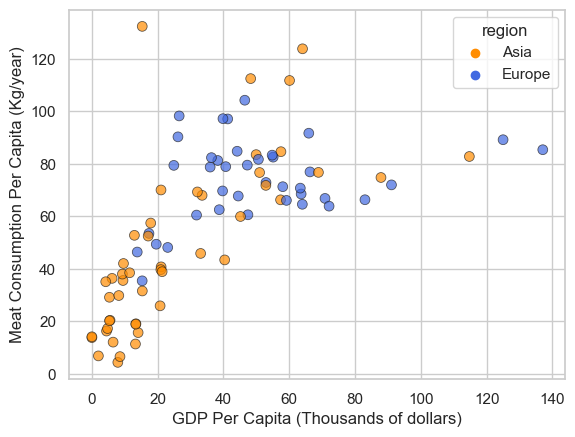

In [50]:
# Make scatter plot

# Take Europe and Asia Dataset
merged_df = pd.read_csv("datasets/merged_meat_fruit_veg.csv")

# Make GDP in thousands of dollars to avoid insane model params later on
merged_df['GDP_per_capita'] /= 1000

# Create scatterplot of GDP to meat consumption
_ = sns.scatterplot(
    data=merged_df,
    x='GDP_per_capita',
    y='Total_Meat_kg_per_capita',
    hue='region',
    palette={'Europe': 'royalblue', 'Asia': 'darkorange'},
    s=50, alpha=0.7, edgecolor='k'
)
_ = plt.xlabel('GDP Per Capita (Thousands of dollars)')
_ = plt.ylabel('Meat Consumption Per Capita (Kg/year)')
plt.show()
# Color EU and AP for comparison only

### Scatterplot Analysis
---
We can see from the scatter plot that there is some positive correlation between GDP per capita and Meat Consumpption per capita, barring a few outliers of extremely wealthy European and Asian countries. We can quantify this relationship through a linear model, which we wil now make.

### Creating training data and making model

In [51]:
# Create model based on training data

# 40% of data used to fit model
# Random state for reproducibility
df_train, df_test = train_test_split(merged_df, test_size=0.4, random_state=111)
meat_model = ols(formula="Total_Meat_kg_per_capita ~ GDP_per_capita", data=df_train).fit()
print(meat_model.params)

# Test model on rest of the data
y_pred = meat_model.predict(df_test)

residuals = df_test['Total_Meat_kg_per_capita'] - y_pred

RSS = np.sum(np.square(residuals))
TSS = np.sum(np.square(df_test['Total_Meat_kg_per_capita']-np.mean(df_test['Total_Meat_kg_per_capita'])))

rsquare = 1 - RSS/TSS
print(f"R^2 = {rsquare:.4f}")

rmse = np.sqrt(RSS/len(df_test))
print(f"RMSE = {rmse:.4f}")

Intercept         33.889778
GDP_per_capita     0.802201
dtype: float64
R^2 = 0.2563
RMSE = 23.2386


### Model Analysis
---

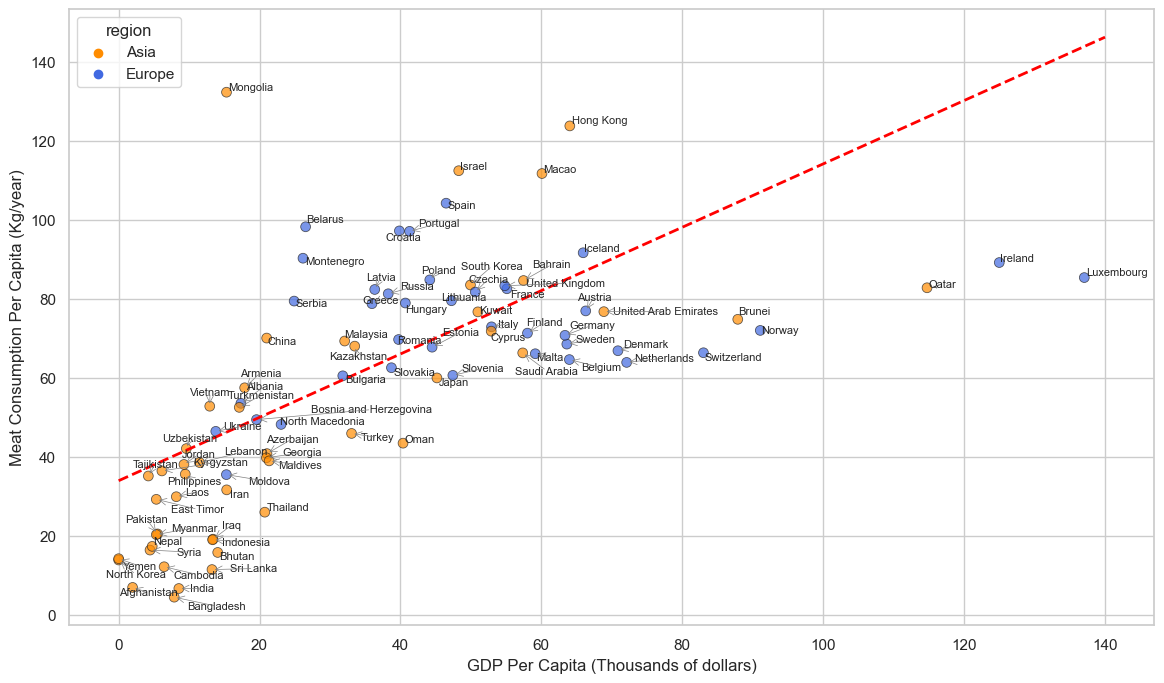

In [52]:
#Draw the graph
# Create scatterplot of GDP to meat consumption
plt.figure(figsize=(14, 8))

_ = sns.scatterplot(
    data=merged_df,
    x='GDP_per_capita',
    y='Total_Meat_kg_per_capita',
    hue='region',
    palette={'Europe': 'royalblue', 'Asia': 'darkorange'},
    s=50, alpha=0.7, edgecolor='k'
)

x_values = pd.DataFrame({'GDP_per_capita': [0, 140]})  # GDP range from 0 to 140k
y_pred = meat_model.predict(x_values)

_ = plt.plot(x_values, y_pred, color='red', linewidth=2, linestyle='--', label=f'Regression Line (R²={meat_model.rsquared:.2f})')

# Create list for all labels
texts = []
for _, row in merged_df.iterrows():
    texts.append(plt.text(row['GDP_per_capita'], 
                        row['Total_Meat_kg_per_capita'], 
                        row['Entity'],
                        fontsize=8))
    
# Adjust text to prevent overlap
adjust_text(texts, 
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.2, 1.2))

_ = plt.xlabel('GDP Per Capita (Thousands of dollars)')
_ = plt.ylabel('Meat Consumption Per Capita (Kg/year)')

We can see some outliers affecting the model. There are a few high GDP per capita nations in both Europe and Asia that do not consume a lot of meat. Apart from these outliers, the relationship holds true. For reference, we will create a new model without these outliers. The outliers are:

- Switzerland
- Ireland
- Brunei
- Qatar
- Luxembourg
- Mongolia
- Norway

We will create a dataframe without these countries to determine a more accurate relationship.

In [53]:
# In merged_df, remove the countries listed in the above markdown,

merged_df_no_outliers = merged_df[~merged_df['Entity'].isin(['Switzerland', 'Ireland', 'Brunei', 'Qatar', 'Luxembourg', 'Mongolia', 'Norway'])]

# Create model based on training data

# 40% of data used to fit model
# Random state for reproducibility
df_train, df_test = train_test_split(merged_df_no_outliers, test_size=0.4, random_state=111)
meat_model_2 = ols(formula="Total_Meat_kg_per_capita ~ GDP_per_capita", data=df_train).fit()
print(meat_model_2.params)

# Test model on rest of the data
y_pred = meat_model_2.predict(df_test)

residuals = df_test['Total_Meat_kg_per_capita'] - y_pred

RSS = np.sum(np.square(residuals))
TSS = np.sum(np.square(df_test['Total_Meat_kg_per_capita']-np.mean(df_test['Total_Meat_kg_per_capita'])))

rsquare = 1 - RSS/TSS
print(f"R^2 = {rsquare:.4f}")

rmse = np.sqrt(RSS/len(df_test))
print(f"RMSE = {rmse:.4f}")


Intercept         24.537214
GDP_per_capita     1.049350
dtype: float64
R^2 = 0.5481
RMSE = 21.3043


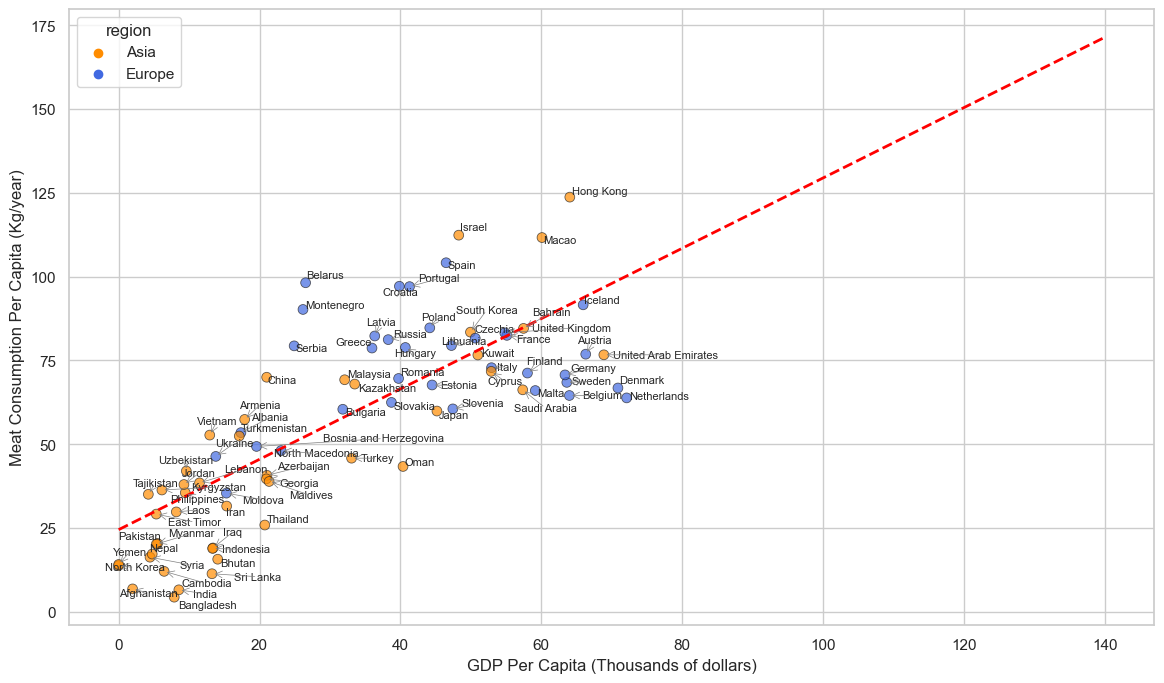

In [54]:
#Draw the graph
# Create scatterplot of GDP to meat consumption
plt.figure(figsize=(14, 8))

_ = sns.scatterplot(
    data=merged_df_no_outliers,
    x='GDP_per_capita',
    y='Total_Meat_kg_per_capita',
    hue='region',
    palette={'Europe': 'royalblue', 'Asia': 'darkorange'},
    s=50, alpha=0.7, edgecolor='k'
)

x_values = pd.DataFrame({'GDP_per_capita': [0, 140]})  # GDP range from 0 to 140k
y_pred = meat_model_2.predict(x_values)

_ = plt.plot(x_values, y_pred, color='red', linewidth=2, linestyle='--', label=f'Regression Line (R²={meat_model_2.rsquared:.2f})')

# Create list for all labels
texts = []
for _, row in merged_df_no_outliers.iterrows():
    texts.append(plt.text(row['GDP_per_capita'], 
                        row['Total_Meat_kg_per_capita'], 
                        row['Entity'],
                        fontsize=8))
    
# Adjust text to prevent overlap
adjust_text(texts, 
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.2, 1.2))

_ = plt.xlabel('GDP Per Capita (Thousands of dollars)')
_ = plt.ylabel('Meat Consumption Per Capita (Kg/year)')

With an R^2 value of almost 0.6, we can see that there is some positive correlation between GDP per capita and meat consumption when adjusting for countries with exceedingly high GDP per capita values. We will therefore use `meat_model_2` as a predictor for meat consumption based on GDP per capita.

### Test Results Breakdown
---
The remainder of this section is dedicated to determining goodness-of-fit for `meat_model_2`. The two tests performed are:
- Bootstrapping x,y pairs and determining a 95% confidence interval for slope and intercept
- Hypothesis testing using random shuffling to determine whether the correlation is real

Both serve to enhance the credibility of `meat_model_2`.

In [55]:
# Helper function to draw bootstrap x,y pairs
# This should draw n number of pairs where n = len(x)
# This should be repeated samples times

def draw_bs_pairs_linreg(x, y, samples = 1):
    inds = np.arange(len(x))
    slopes = np.zeros(samples)
    intercepts = np.zeros(samples)
    
    for i in range(samples):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds] 
        slopes[i], intercepts[i] = np.polyfit(bs_x, bs_y, 1)
        
    return slopes, intercepts

Slope from OLS = 1.0494
Intercept from OLS = 24.5372
95% Bootstrap confidence interval of slope lies between 0.8556 and 1.2370
95% Bootstrap confidence interval of intercept lies between 17.5391 and 30.1923


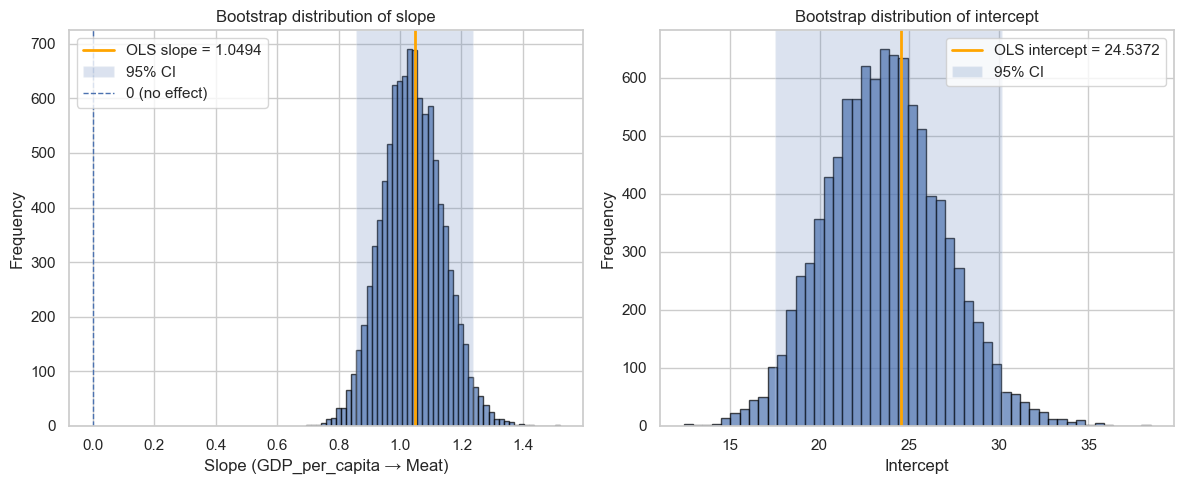

In [56]:
# Goodness of fit 1

# For this, let's figure out whether the slope is random or actually caused by the data
# As a reminder, the slope made by OLS:
print(f"Slope from OLS = {meat_model_2.params['GDP_per_capita']:.4f}")
print(f"Intercept from OLS = {meat_model_2.params['Intercept']:.4f}")

# Now, let's bootstrap 10000 slopes and intercepts and see how the confidence intervals fare
bs_slopes, bs_intercepts = draw_bs_pairs_linreg(merged_df_no_outliers['GDP_per_capita'].to_numpy(), merged_df_no_outliers['Total_Meat_kg_per_capita'].to_numpy(), 10000)

# Find 95% confidence intervals of slopes and intercepts obtained from bootstrap
bs_slopes_confint = np.percentile(bs_slopes, [2.5, 97.5])
bs_intercepts_confint = np.percentile(bs_intercepts, [2.5, 97.5])

# Print out results
print(f"95% Bootstrap confidence interval of slope lies between {bs_slopes_confint[0]:.4f} and {bs_slopes_confint[1]:.4f}")
print(f"95% Bootstrap confidence interval of intercept lies between {bs_intercepts_confint[0]:.4f} and {bs_intercepts_confint[1]:.4f}")

# Draw histograms to plot the distribution of slopes and intercepts and plop down our slope and intercept
# Save ols_slope and ols_intercept first
ols_slope = meat_model_2.params['GDP_per_capita']
ols_intercept = meat_model_2.params['Intercept']

# Histograms with OLS lines and CI bands
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Slope ---
axes[0].hist(bs_slopes, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(ols_slope, linewidth=2, label=f'OLS slope = {ols_slope:.4f}', color='orange')
axes[0].axvspan(bs_slopes_confint[0], bs_slopes_confint[1], alpha=0.2, label='95% CI')
axes[0].axvline(0, linestyle='--', linewidth=1, label='0 (no effect)')
axes[0].set_title('Bootstrap distribution of slope')
axes[0].set_xlabel('Slope (GDP_per_capita → Meat)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# --- Intercept ---
axes[1].hist(bs_intercepts, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(ols_intercept, linewidth=2, label=f'OLS intercept = {ols_intercept:.4f}', color='orange')
axes[1].axvspan(bs_intercepts_confint[0], bs_intercepts_confint[1], alpha=0.2, label='95% CI')
axes[1].set_title('Bootstrap distribution of intercept')
axes[1].set_xlabel('Intercept')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

In [57]:
# Next - Permutation hypothesis test
# Shuffle data randomly and draw a line of best fit
# Helper function to shuffle data randomly and draw a line of best fit
    
def draw_perm_replicates(x, y, reps=1):
    # Initialise array
    slope_replicates = np.zeros(reps)
    
    # Make reps number of replicate slopes
    for i in range(reps):
        y_perm = np.random.permutation(y)
        slope_replicates[i], _ = np.polyfit(x, y_perm, 1)
        
    return slope_replicates


Slope from OLS = 1.0494

If the data was randomly distributed...
99% Confidence interval of slope lies between -0.3784 and 0.3765

P-value = 0.0


c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


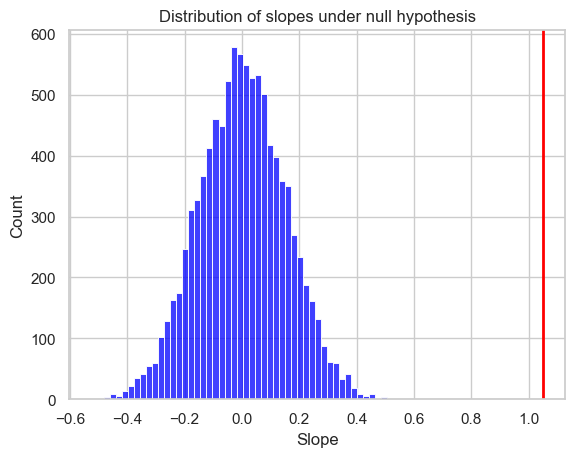

In [58]:
# Do this 10k times to get 10k slopes
# Draw a histogram of 10k slopes and teh 95% Ci
# Use p value to show that our slope blows it out of the water
# Conclusion: statistically significant

# Computed slope through OLS
print(f"Slope from OLS = {meat_model_2.params['GDP_per_capita']:.4f}\n")

# Get 10k slopes from permutation
slope_replicates = draw_perm_replicates(merged_df_no_outliers['GDP_per_capita'].to_numpy(), merged_df_no_outliers['Total_Meat_kg_per_capita'].to_numpy(), 10000)

# Get 99% CI of slope replicates
perm_slopes_confint = np.percentile(slope_replicates, [0.5, 99.5])
print("If the data was randomly distributed...")
print(f"99% Confidence interval of slope lies between {perm_slopes_confint[0]:.4f} and {perm_slopes_confint[1]:.4f}")

# Find P value for the absolute value of the slope being the OLS slope or higher.
ols_slope = meat_model_2.params['GDP_per_capita']

p_val = np.sum(slope_replicates >= ols_slope)/len(slope_replicates)
print(f"\nP-value = {p_val}")

# Plot null distribution with observed slope
plt.figure()
sns.histplot(slope_replicates, bins=50, color='blue')
plt.axvline(ols_slope, linestyle='-', linewidth=2, color='red')
plt.title("Distribution of slopes under null hypothesis")
plt.xlabel("Slope")
plt.ylabel("Count")
plt.show()

### Final Thoughts on Model
---
After all of that, our final linear regression model proves a quantifiable, positive relationship between a nation's wealth and its meat consumption:

Final model is Meat consumption = 1.0494 * GDP + 24.5372

The slope of ~1.05 is our key finding and proof of concept. It shows that for every additional thousand dollars in GDP per capita, a country's per capita meat consumption tends to increase by about 1.05 kg per year. We get a tangible link between economic development and dietary change.

## 4.2 Linear Regression 2 - Vegetables
----
Time to analyse the predictors of vegetable consumption

### Possible regressors
---
- GDP Per capita
- Caloric Intake
- Urbanisation

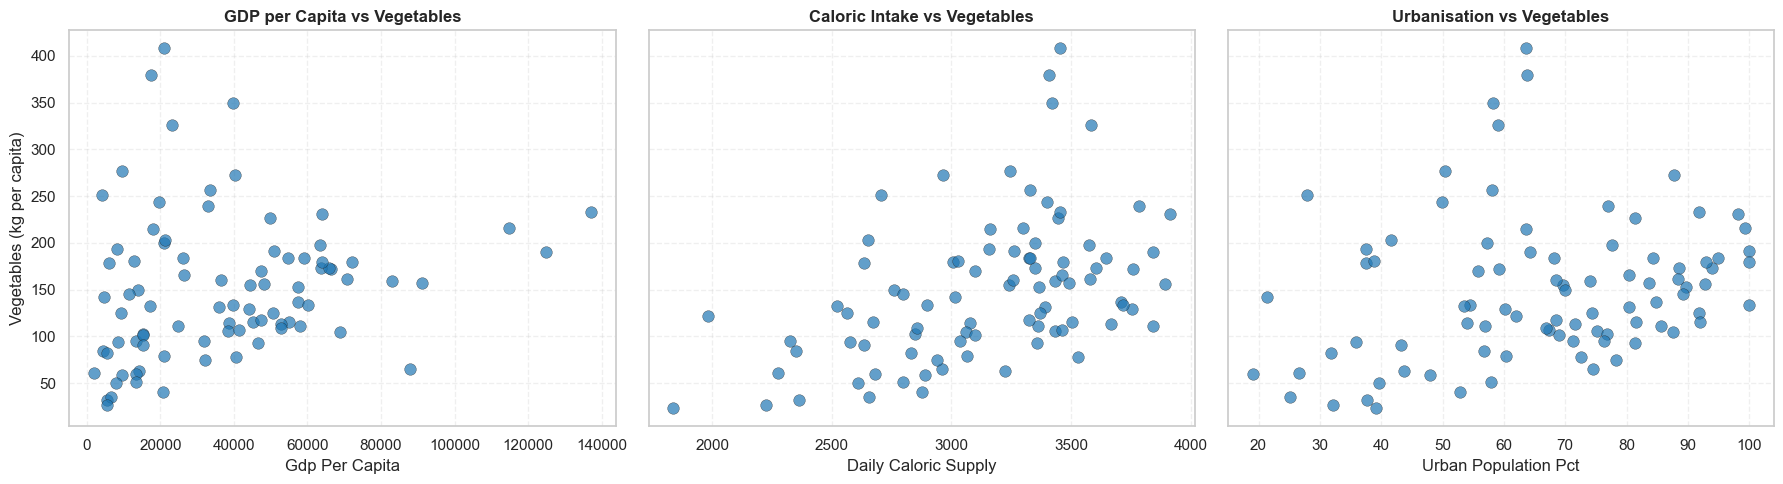

In [59]:
# Draw scatterplots of GDP/Caloric/Urbanisation against veg

merged_df = pd.read_csv("datasets/merged_meat_veg_caloric_urban.csv")

GDP = merged_df['GDP_per_capita']
veg = merged_df['Vegetables_kg_per_capita']
urbanisation = merged_df['Urban_population_pct']
caloric_intake = merged_df['Daily_caloric_supply']

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

pairs = [
    (GDP,            veg, "GDP per Capita vs Vegetables"),
    (caloric_intake, veg, "Caloric Intake vs Vegetables"),
    (urbanisation,   veg, "Urbanisation vs Vegetables"),
]

for ax, (x, y, title) in zip(axes, pairs):
    sns.scatterplot(
        x=x, y=y,
        s=70, alpha=0.7,
        edgecolor='k', linewidth=0.3,
        color='tab:blue',  # single color
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(x.name.replace('_', ' ').title())
    ax.set_ylabel("Vegetables (kg per capita)" if ax is axes[0] else "")
    ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Notes
---
We can see that there is a weak positive correlation between the three regressors and vegetable consumption, though it is not as clear as meat consumption. We will try a few models based on these regressors to see which one fits the best.

In [60]:
# Helper function to determine Rsquared and RMSE for test data and training data
# What do we need?
# The model
# The data we are going to use predict on

def calculate_fit_goodness_veg(model, data):
    y_pred = model.predict(data)

    residuals = data['Vegetables_kg_per_capita'] - y_pred

    RSS = np.sum(np.square(residuals))
    TSS = np.sum(np.square(data['Vegetables_kg_per_capita']-np.mean(data['Vegetables_kg_per_capita'])))

    rsquare = 1 - RSS/TSS
    rmse = np.sqrt(RSS/len(data))
    
    return rsquare, rmse

In [61]:
from tabulate import tabulate

# Split dataset into training and testing
df_train, df_test = train_test_split(merged_df, test_size=0.5)

# Create the array of formulae
formulas = {
    "Urbanisation":                 "Vegetables_kg_per_capita ~ Urban_population_pct",
    "GDP":                          "Vegetables_kg_per_capita ~ GDP_per_capita",
    "Caloric intake":               "Vegetables_kg_per_capita ~ Daily_caloric_supply",
    "Urbanisation + GDP":           "Vegetables_kg_per_capita ~ Urban_population_pct + GDP_per_capita",
    "Urbanisation + Caloric":       "Vegetables_kg_per_capita ~ Urban_population_pct + Daily_caloric_supply",
    "GDP + Caloric":                "Vegetables_kg_per_capita ~ GDP_per_capita + Daily_caloric_supply",
    "Urbanisation + GDP + Caloric": "Vegetables_kg_per_capita ~ Urban_population_pct + GDP_per_capita + Daily_caloric_supply",
}

# --- helper: get predictor columns from a simple + formula ---
def predictors_in(formula: str):
    rhs = formula.split("~", 1)[1]
    return [c.strip() for c in rhs.split("+")]

results = []

for name, formula in formulas.items():
    preds = predictors_in(formula)
    needed = ['Vegetables_kg_per_capita'] + preds

    # drop rows with NAs only for the columns this model needs
    train_use = df_train.dropna(subset=needed).copy()
    test_use  = df_test.dropna(subset=needed).copy()

    # fit on TRAIN only
    model = ols(formula, data=train_use).fit()

    # metrics on TRAIN and TEST
    r2_tr, rmse_tr = calculate_fit_goodness_veg(model, train_use)
    r2_te, rmse_te = calculate_fit_goodness_veg(model, test_use)

    results.append({
        "Model": name,
        "Predictors": ", ".join(preds),
        "n_train": len(train_use),
        "n_test": len(test_use),
        "Train_R2": round(r2_tr, 3) if pd.notna(r2_tr) else np.nan,
        "Train_RMSE": round(rmse_tr, 3) if pd.notna(rmse_tr) else np.nan,
        "Test_R2": round(r2_te, 3) if pd.notna(r2_te) else np.nan,
        "Test_RMSE": round(rmse_te, 3) if pd.notna(rmse_te) else np.nan,
    })

# tidy comparison table (sorted by test RMSE ascending)
results_df = pd.DataFrame(results).sort_values(["Test_RMSE", "Train_RMSE"], ascending=[True, True]).reset_index(drop=True)
print(tabulate(results_df, headers='keys', tablefmt='psql'))

+----+------------------------------+------------------------------------------------------------+-----------+----------+------------+--------------+-----------+-------------+
|    | Model                        | Predictors                                                 |   n_train |   n_test |   Train_R2 |   Train_RMSE |   Test_R2 |   Test_RMSE |
|----+------------------------------+------------------------------------------------------------+-----------+----------+------------+--------------+-----------+-------------|
|  0 | Caloric intake               | Daily_caloric_supply                                       |        43 |       44 |      0.194 |       75.854 |     0.206 |      59.581 |
|  1 | GDP + Caloric                | GDP_per_capita, Daily_caloric_supply                       |        42 |       43 |      0.223 |       75.231 |     0.106 |      61.43  |
|  2 | Urbanisation + Caloric       | Urban_population_pct, Daily_caloric_supply                 |        43 |       44 

### Conclusion for Vegetable Consumption Linear Regression
---

When it comes to the training data, Urbanisation + GDP + Caloric intake seems to give the "least worst" error. However, when we go back to the original test data, we find that caloric supply is the best regressor to determine a relationship between itself and vegetable consumption

# Chapter 5: Overall Conclusion — The End
---
## Answering our questions posed in the intro:
1. Do Europeans consume more meat than Asians?

- Where: Histograms, boxplots, summary statistics, permutation test.

- Answer:
EDA clearly suggested that European countries consume more meat on average than Asian countries. Boxplots showed us Europe’s median meat intake is higher, and histograms illustrated that most European countries cluster around higher values. The permutation test confirmed this difference is unlikely to be due to random chance.

- Why it matters: This aligns with common nutritional stereotypes (Western diets being more meat-heavy), and establishing it quantitatively grounds the rest of the analysis.

2. Do Asians consume more vegetables than Europeans?

- Where: Histograms, boxplots, summary statistics.

- Answer:
The distributions showed that Asian countries tend toward higher vegetable intake compared to Europe, although the difference was less stark than for meat. Variation was large, but the overall trend supported the hypothesis.

- Why it matters: This complements the first question, suggesting a contrast: Europe leans meat-heavy, Asia leans plant-heavy — though it is not an absolute rule.

3. Is there a trade-off between meat and vegetable consumption?

- Where: Scatterplot (meat vs. vegetable).

- Answer:
The scatterplot showed only a weak negative association: countries that eat a lot of meat don’t necessarily eat fewer vegetables. Some countries have high levels of both, while others have low levels of both.

- Why it matters: This tells us diets aren’t strictly a substitution (meat vs. vegetables). Instead, overall consumption levels vary by country, reflecting cultural, economic, and agricultural influences.

4. How variable are diets within each region?

- Where: Summary statistics (SD, range).

- Answer:
Asian countries showed much larger variability in both meat and vegetable consumption. Some countries were among the lowest globally, while others were near the highest. European diets were more clustered and consistent.

- Why it matters: This highlights that Asia is not homogeneous — it includes very different dietary cultures. Europe, on the other hand, appears more uniform in its meat consumption habits.

5. Are the observed differences statistically significant?

- Where: Permutation test (meat).

- Answer:
The permutation test gave strong evidence that Europe’s higher meat consumption is statistically significant, not just random variation. For vegetables, significance was weaker but the descriptive trend still held.

- Why it matters: EDA can suggest patterns, but hypothesis testing allows us to claim these differences with greater confidence.

6. What does bootstrapping tell us about confidence in our findings?

- Where: Bootstrap resampling of mean differences.

- Answer:
Bootstrapped confidence intervals showed that the mean difference in meat consumption (Europe > Asia) is consistently positive, strengthening confidence in the result. For vegetables, the interval was wider, reflecting more uncertainty.

- Why it matters: Bootstrapping quantifies uncertainty and shows whether the trends hold across resampled datasets. It reassures us that the meat result is robust, while the vegetable finding is less clear-cut.

7. Does GDP per capita predict meat consumption?

- Where: Regression analysis (OLS).

- Answer:
The regression found a positive slope: richer countries tend to consume more meat. However, the relationship wasn’t perfectly strong — other factors clearly play a role.

- Why it matters: This connects diet to economic development, a known theme in nutrition studies. It suggests wealth enables higher meat consumption, which fits global patterns of “nutrition transition.”

# Data Sources
---
All data gathered from Our World in Data. Links are below formatted in APA citation format:

- (2015). Ourworldindata.org. https://ourworldindata.org/grapher/per-capita-meat-type.csv?v=1&csvType=full&useColumnShortNames=true

- (2015). Ourworldindata.org. https://ourworldindata.org/grapher/daily-per-capita-caloric-supply.csv?v=1&csvType=full&useColumnShortNames=true

- (2015). Ourworldindata.org. https://ourworldindata.org/grapher/gdp-per-capita-worldbank.csv?v=1&csvType=full&useColumnShortNames=true

- (2015). Ourworldindata.org. https://ourworldindata.org/grapher/share-of-population-urban.csv?v=1&csvType=full&useColumnShortNames=true

- (2015). Ourworldindata.org. https://ourworldindata.org/grapher/vegetable-consumption-per-capita.csv?v=1&csvType=full&useColumnShortNames=true

‌